In [195]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import tensorflow as tf
import tensorflow_addons as tfa
import sys
sys.path.append("..")
import os
from PIL import Image
import keras, keras.layers as L, keras.backend as K
from sklearn.model_selection import train_test_split
%matplotlib inline
import keras.utils
import pylops
import pickle
import pyproximal
import bm3d

from pylops.config import set_ndarray_multiplication
plt.close('all')
np.random.seed(0)
set_ndarray_multiplication(False) 
import cv2
from tqdm.notebook import tqdm

import torch
import torch.utils as utils
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [196]:
import os 
import cv2
import numpy as np
from tqdm import tqdm

REBUILD_DATA=True

class Denoising():
    IMG_SIZE=256 
    label_dir='train'
    training_data=[]
    
    def make_training_data(self):
        for f in tqdm(os.listdir(self.label_dir)):
            
            try:
                path=os.path.join(self.label_dir,f)
                img=cv2.resize(img,(self.IMG_SIZE,self.IMG_SIZE))
                self.training_data.append(np.array(img))

            except Exception as e:
                pass
            
        np.save('training_data.npy',self.training_data)
        
if (REBUILD_DATA):
    denoising=Denoising()
    denoising.make_training_data()

100%|███████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 21430.75it/s]


In [198]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"# Using device: {device}")

# Using device: cpu


In [199]:
torch.cuda.empty_cache()

In [201]:
training_data=np.load('training_data.npy',allow_pickle=True)
len(training_data)

180

In [202]:
training_data.shape

(180, 256, 256)

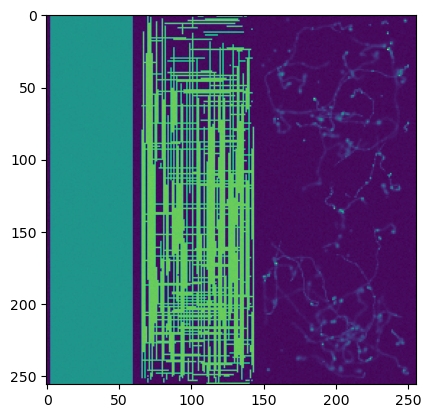

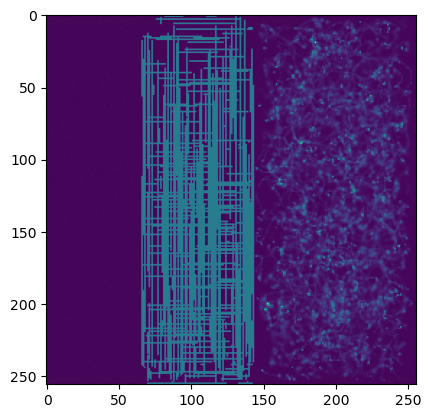

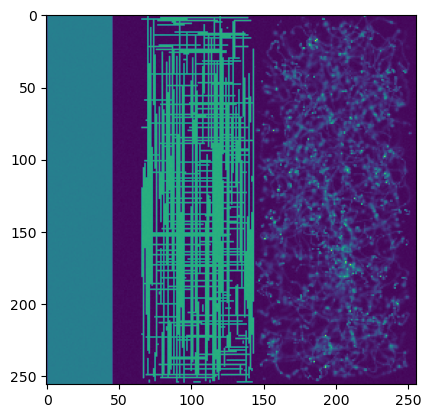

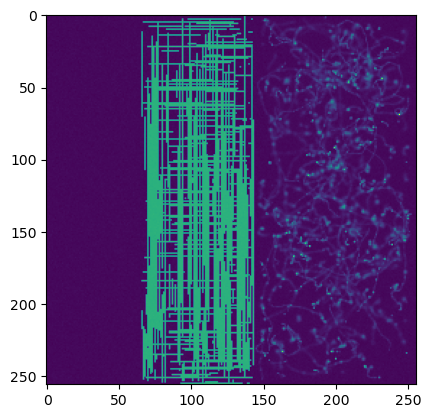

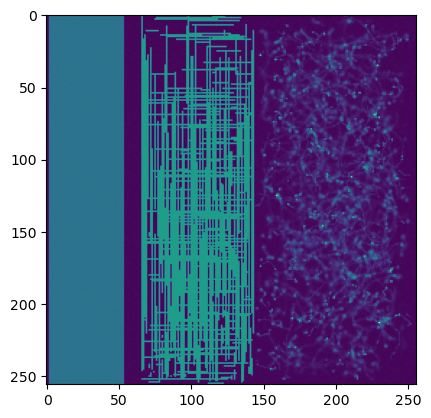

In [203]:
for i in range(0,len(training_data),40):
    plt.imshow(training_data[i])
    plt.show()

In [ ]:
def build_pca_autoencoder(training_data.shape, code_size):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Flatten())                  #flatten image to vector
    encoder.add(L.Dense(code_size))           #actual encoder

    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(np.prod(img_shape)))  #actual decoder, height*width*3 units
    decoder.add(L.Reshape(img_shape))         #un-flatten
    
    return encoder,decode

In [ ]:
tqdm_callback = tfa.callbacks.TQDMProgressBar()

encoder, decoder = build_pca_autoencoder(IMG_SHAPE, code_size=32)

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

autoencoder.fit(x=X_train, y=X_train, epochs=15,
                validation_data=[X_test, X_test],
                callbacks=[tqdm_callback],
                verbose=0)

In [204]:
IMG_SIZE=256

EPOCHS = 1000
batch_size = 4
learning_rate = 0.00005

In [205]:
train_loader = torch.utils.data.DataLoader(dataset=training_data,batch_size=batch_size,shuffle=False)

for data in train_loader:
    print(data.size())
    print(type(data))
    break

torch.Size([4, 256, 256])
<class 'torch.Tensor'>


In [206]:
X_orig=torch.Tensor([training_data[i] for i in range(0,len(training_data),4)])
X_noisy=torch.Tensor([training_data[i] for i in range(2,len(training_data),4)])

X_orig=X_orig/255
X_noisy=X_noisy/255

C:\Users\dodo\AppData\Local\Temp\ipykernel_5792\3814672331.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  X_orig=torch.Tensor([training_data[i] for i in range(0,len(training_data),4)])


In [207]:
X_dev=(X_orig-X_noisy)
mean_dev=X_dev.mean()
std_dev=X_dev.std()

print(mean_dev,std_dev)

tensor(0.0313) tensor(3.8742)


In [210]:
print('X_orig: ',X_orig.size())

X_orig_T=np.transpose(X_orig,(0,2,1))
X_noisy_T=np.transpose(X_noisy,(0,2,1))
print('X_orig_T: ',X_orig_T.shape)

X_orig_flat=X_orig_T.reshape(-1,1,IMG_SIZE,IMG_SIZE)
X_noisy_flat=X_noisy_T.reshape(-1,1,IMG_SIZE,IMG_SIZE)
print('X_orig_flat: ',X_orig_flat.shape)

X_orig:  torch.Size([45, 256, 256])
X_orig_T:  torch.Size([45, 256, 256])
X_orig_flat:  torch.Size([45, 1, 256, 256])


In [212]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,32,3,padding=1),   # batch x 32 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(32),             
                        nn.Conv2d(32,32,3,padding=1),   # batch x 32 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 64 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Conv2d(64,64,3,padding=1),  # batch x 64 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)   # batch x 64 x 128 x 128
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),  # batch x 128 x 128 x 128
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(128,128,3,padding=1),  # batch x 128 x 128 x 128
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1),  # batch x 256 x 64 x 64
                        nn.ReLU()
        )      
                
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out
    
encoder = Encoder().cpu()

In [213]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,128,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.ConvTranspose2d(64,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,1,3,2,1,1),
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = x.view(batch_size,256,64,64)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

decoder = Decoder().cpu()

In [215]:
train_orig_loader = torch.utils.data.DataLoader(dataset=X_orig_flat,batch_size=batch_size,shuffle=False)
train_noisy_loader = torch.utils.data.DataLoader(dataset=X_noisy_flat,batch_size=batch_size,shuffle=False)

for train_orig,train_noisy in zip(train_orig_loader,train_noisy_loader):
    orig_image = Variable(train_orig).cpu()
    noisy_image = Variable(train_noisy).cpu()
    
    encoder_op = encoder(noisy_image)
    output = decoder(encoder_op)
    
    print('Image Dim: ',orig_image.size())
    print('Noisy Image Dim: ',noisy_image.size())
    print('Encoder Output Dim: ',encoder_op.size())
    print('Output Dim: ',output.size())
    break

Image Dim:  torch.Size([4, 1, 256, 256])
Noisy Image Dim:  torch.Size([4, 1, 256, 256])
Encoder Output Dim:  torch.Size([4, 1048576])
Output Dim:  torch.Size([4, 1, 256, 256])


In [221]:
# loss func and optimizer
# Computing reconstruction after decoder so use Mean Squared Error
# In order to use multi parameters with one optimizer, concat parameters after changing into list

parameters = list(encoder.parameters())+ list(decoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.AdamW(parameters, lr=learning_rate)
losses=[]

for epoch in tqdm(range(EPOCHS)):
    
    rand_idx=torch.randperm(X_orig.size()[0])
    X_orig_iter=X_orig[rand_idx]
    X_noisy_iter=X_noisy[rand_idx]

    X_orig_iter=np.transpose(X_orig_iter,(0,2,1))
    X_noisy_iter=np.transpose(X_noisy_iter,(0,2,1))

    added_noise=torch.randn(X_noisy_iter.size())*std_dev+mean_dev
    X_noisy_iter=X_noisy_iter+added_noise

    X_orig_iter=X_orig_iter.reshape(-1,1,IMG_SIZE,IMG_SIZE)
    X_noisy_iter=X_noisy_iter.reshape(-1,1,IMG_SIZE,IMG_SIZE)

    train_orig_loader = torch.utils.data.DataLoader(dataset=X_orig_iter,batch_size=batch_size,shuffle=False)
    train_noisy_loader = torch.utils.data.DataLoader(dataset=X_noisy_iter,batch_size=batch_size,shuffle=False)

    for train_orig,train_noisy in zip(train_orig_loader,train_noisy_loader):
        orig_image = Variable(train_orig).cpu()
        noisy_image = Variable(train_noisy).cpu()
        
        optimizer.zero_grad()

        encoder_op = encoder(noisy_image)
        output = decoder(encoder_op)
        
        loss=loss_func(output,orig_image)
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    
torch.save([encoder,decoder],'denoising_autoencoder.pkl')

  0%|          | 0/1000 [00:00<?, ?it/s]

RuntimeError: shape '[4, 256, 64, 64]' is invalid for input of size 1048576

In [ ]:
train_noisy_loader = torch.utils.data.DataLoader(dataset=X_noisy_flat,batch_size=batch_size,shuffle=False)

denoised_output=[]
for train_noisy in tqdm(train_noisy_loader):
    noisy_image = Variable(train_noisy).cpu()
    
    encoder_op = encoder(noisy_image)
    output = decoder(encoder_op)
    
    output=output.cpu()
    output=output.detach()
    denoised_output.append(output)

In [224]:
X_denoised=denoised_output

X_denoised=torch.stack(X_denoised)
print(X_denoised.size())

X_denoised=X_denoised.view(256)
print(X_denoised.size())

X_denoised=X_denoised.view(256)
print(X_denoised.size())

X_denoised=X_denoised.permute(0,2,1)
print(X_denoised.shape)


torch.Size([11, 4, 1, 256, 256])


RuntimeError: shape '[256]' is invalid for input of size 2883584

TypeError: Invalid shape (4, 1, 256, 256) for image data

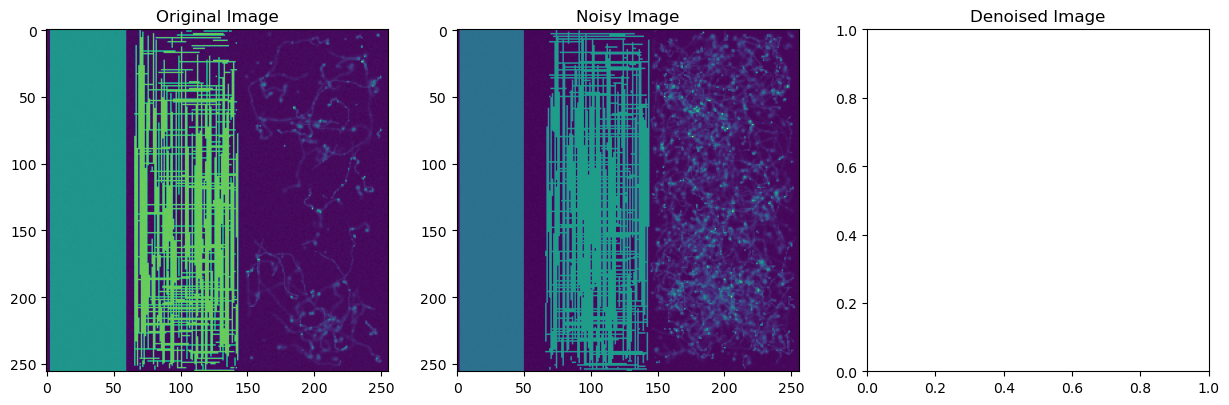

In [225]:
for i in range(0,len(X_orig),10):
    
    fig=plt.figure(figsize=(15, 5))
    
    ax = plt.subplot(131)
    plt.title('Original Image')
    plt.imshow(X_orig[i])
    
    ax = plt.subplot(132)
    plt.title('Noisy Image')
    plt.imshow(X_noisy[i])
    
    ax = plt.subplot(133)
    plt.title('Denoised Image')
    plt.imshow(X_denoised[i])
    plt.show()

In [226]:
X_denoised=X_denoised.numpy()
X_orig=X_orig.numpy()

X_orig=X_orig*255
X_denoised=X_denoised*255

ref_mat=X_orig
res_mat=X_denoised

print(ref_mat.shape)
print(res_mat.shape)

(45, 256, 256)
(11, 4, 1, 256, 256)


In [231]:
ref_mat = ref_mat.astype('float') / 255.0
res_mat = res_mat.astype('float') / 255.0

def output_psnr_mse(img_orig, img_out):
    squared_error = np.square(img_orig - img_out)
    mse = np.mean(squared_error)
    psnr = 10 * np.log10(1.0 / mse)
    return psnr

def mean_psnr_srgb(ref_mat, res_mat):
    n_blk,h, w = ref_mat.shape
    mean_psnr = 0
    for b in range(n_blk):
        ref_block = ref_mat[b, :, :,:]
        res_block = res_mat[b, :, :,:]
        ref_block = np.reshape(ref_block, (h, w,c))
        res_block = np.reshape(res_block, (h, w,c))
        psnr = output_psnr_mse(ref_block, res_block)
        mean_psnr += psnr
    return mean_psnr / n_blk

#PSNR
mean_psnr = mean_psnr_srgb(ref_mat, res_mat)
print('mean_psnr:')
print(mean_psnr)

IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

In [232]:
from skimage.metrics import structural_similarity as ssim

def mean_ssim_srgb(ref_mat, res_mat):
    n_blk, h, w, c = ref_mat.shape
    mean_ssim = 0
    for b in range(n_blk):
        ref_block = ref_mat[b, :, :, :]
        res_block = res_mat[b, :, :, :]
        ref_block = np.reshape(ref_block, (h, w, c))
        res_block = np.reshape(res_block, (h, w, c))
        ssim1 = ssim(ref_block, res_block, gaussian_weights=True, use_sample_covariance=False,
                     multichannel=True)
        mean_ssim += ssim1
    return mean_ssim / n_blk

# SSIM
mean_ssim = mean_ssim_srgb(ref_mat, res_mat)
print('mean_ssim:')
print(mean_ssim)

ValueError: not enough values to unpack (expected 4, got 3)

In [240]:
x = np.load('training_data.npy')
x = x / x.max()
ny, nx,nz = x.shape

perc_subsampling = 0.6
nxsub = int(np.round(ny * nx * perc_subsampling))
iava = np.sort(np.random.permutation(np.arange(ny * nx))[:nxsub])
Rop = pylops.Restriction(ny * nx * nz, iava, dtype=np.complex128)
Fop = pylops.signalprocessing.FFT2D(dims=(ny, nx,nz))

TypeError: Invalid shape (180, 256, 256) for image data

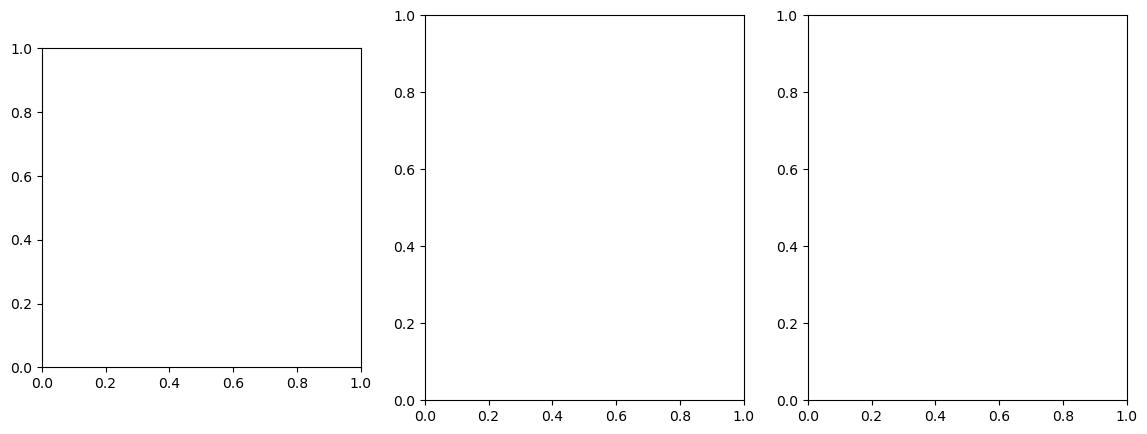

In [244]:
y = Rop * Fop * x.ravel()
yfft = Fop * x.ravel()
yfft = np.fft.fftshift(yfft.reshape(ny, nx,nz))

ymask = Rop.mask(Fop * x.ravel())
ymask = ymask.reshape(ny, nx, nz)
ymask.data[:] = np.fft.fftshift(ymask.data)
ymask.mask[:] = np.fft.fftshift(ymask.mask)

fig, axs = plt.subplots(1, 3, figsize=(14, 5))
axs[0].imshow(x, vmin=0, vmax=1, cmap="gray")
axs[0].set_title("Model")
axs[0].axis("tight")
axs[1].imshow(np.abs(yfft), vmin=0, vmax=1, cmap="rainbow")
axs[1].set_title("Full data")
axs[1].axis("tight")
axs[2].imshow(np.abs(ymask), vmin=0, vmax=1, cmap="rainbow")
axs[2].set_title("Sampled data")
axs[2].axis("tight")
plt.tight_layout()

At this point we create a denoiser instance using the BM3D algorithm and use
as Plug-and-Play Prior to the ADMM algorithm

In [245]:
def callback(x, xtrue, errhist):
    errhist.append(np.linalg.norm(x - xtrue))

Op = Rop * Fop
L = np.real((Op.H*Op).eigs(neigs=1, which='LM')[0])
tau = 1./L
sigma = 0.05

l2 = pyproximal.proximal.L2(Op=Op, b=y.ravel(), niter=50, warm=True)

# BM3D denoiser
denoiser = lambda x, tau: bm3d.bm3d(np.real(x), sigma_psd=sigma * tau,
                                    stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)

errhist = []
xpnp = pyproximal.optimization.pnp.PlugAndPlay(l2, denoiser, x.shape,
                                               tau=tau, x0=np.zeros(x.size),
                                               niter=40, show=True,
                                               callback=lambda xx: callback(xx, x.ravel(),
                                                                            errhist))[0]
xpnp = np.real(xpnp.reshape(x.shape))

fig, axs = plt.subplots(1, 2, figsize=(9, 5))
axs[0].imshow(x, vmin=0, vmax=1, cmap="gray")
axs[0].set_title("Model")
axs[0].axis("tight")
axs[1].imshow(xpnp, vmin=0, vmax=1, cmap="gray")
axs[1].set_title("PnP Inversion")
axs[1].axis("tight")
plt.tight_layout()

plt.figure(figsize=(12, 3))
plt.plot(errhist, 'k', lw=2)
plt.title("Error norm")
plt.tight_layout()

ADMM
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.optimization.pnp._Denoise'>
tau = 1.000000e+00	niter = 40

   Itn       x[0]          f           g       J = f + g


C:\Users\dodo\anaconda3\lib\site-packages\pyproximal\optimization\primal.py:678: ComplexWarning: Casting complex values to real discards the imaginary part
  msg = '%6g  %12.5e  %10.3e  %10.3e  %10.3e' % \


     1  -1.72009e-02   1.949e+01   0.000e+00   1.949e+01


KeyboardInterrupt: 